#### Apply time series model and compare mean aboverage percentage error

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sb
plt.rcParams['figure.figsize'] = (18, 9)

# ETL (extract, transform, load)

## load csv, shp file

In [2]:
#load into main df_csv
df_csv = pd.read_csv('rm_crop_yields_1938_2021.csv')

In [3]:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25017 entries, 0 to 25016
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          25017 non-null  int64  
 1   RM            25017 non-null  int64  
 2   Winter Wheat  3037 non-null   float64
 3   Canola        14008 non-null  float64
 4   Spring Wheat  24924 non-null  float64
 5   Mustard       4487 non-null   float64
 6   Durum         11581 non-null  float64
 7   Sunflowers    946 non-null    float64
 8   Oats          23913 non-null  float64
 9   Lentils       5515 non-null   float64
 10  Peas          8134 non-null   float64
 11  Barley        24703 non-null  float64
 12  Fall Rye      15847 non-null  float64
 13  Canary Seed   3819 non-null   float64
 14  Spring Rye    805 non-null    float64
 15  Tame Hay      4205 non-null   float64
 16  Flax          20934 non-null  float64
 17  Chickpeas     960 non-null    float64
dtypes: float64(16), int64(2)
m

In [4]:
df_csv.rename(columns={"Winter Wheat": "WinterWheat", "Spring Wheat": "SpringWheat","Fall Rye":"FallRye",\
             "Canary Seed":"CanarySeed","Spring Rye":"SpringRye","Tame Hay":"TameHay"},inplace=True)

In [5]:
#https://saskpulse.com
#https://www.rayglen.com/grain-conversion-calculator/
# (lbs/ac) -> Mustard (50 lbs/bu), Sunflower (30 lbs/bu), Lentils (60 lbs/bu), 
#             Canary Seeed (50 lbs/bu), Chickpeas (60lb/bu)

# Tame Hay (tons/ac)
# All the rest are bushel/acre (bu/ac)
df_csv['Mustard']=df_csv['Mustard']/50
df_csv['Sunflowers']=df_csv['Sunflowers']/30
df_csv['Lentils']=df_csv['Lentils']/60
df_csv['CanarySeed']=df_csv['CanarySeed']/50
df_csv['Chickpeas']=df_csv['Chickpeas']/60

df_csv.drop(['TameHay'],axis=1,inplace=True)

In [6]:
#load shp data
gdf = gpd.read_file('Rural Municipality.shp')

#drop columns that won't be using
gdf.drop(['PPID','EFFDT','EXPDT','FEATURECD','SHAPE_AREA','SHAPE_LEN'],axis=1,inplace=True)

#rename column to match with main df
gdf.rename(columns=
{   'RMNO': 'RM',
    'RMNM': 'Municipality'
}, inplace=True)

#match data type between df_csv and gdf
gdf['RM']=gdf['RM'].astype('int')
gdf['Municipality']=gdf['Municipality'].astype('string')


In [7]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   RM            298 non-null    int64   
 1   Municipality  298 non-null    string  
 2   geometry      298 non-null    geometry
dtypes: geometry(1), int64(1), string(1)
memory usage: 7.1 KB


# EDA (Extrapolatory Data Analysis)

#### check for unique values

In [8]:
gdf['RM'].unique()
gdf['RM'].nunique()
#298 unique RM

298

#### check for duplicated values

In [9]:
gdf.duplicated().sum()

0

In [10]:
df_describe = df_csv.describe().copy()
df_describe
# Total of 25017 rows
# Year from 1938 to 2021 ~ 84 years
# 299 RM from 1 to 622 
# Spring Wheat, Barley and Oats have the most rows -> more complete data?
# Oats, Winter Wheat, Barley has the most mean -> most yield
# Tame Hay, Spring Rye, Flax have the least mean -> least yield

,Year,RM,WinterWheat,Canola,SpringWheat,Mustard,Durum,Sunflowers,Oats,Lentils,Peas,Barley,FallRye,CanarySeed,SpringRye,Flax,Chickpeas
count,25017.000000,25017.000000,3037.00000,14008.000000,24924.000000,4487.000000,11581.000000,946.000000,23913.000000,5515.000000,8134.000000,24703.000000,15847.000000,3819.000000,805.000000,20934.000000,960.000000
mean,1979.385938,248.957509,38.24350,24.146796,25.778733,16.883719,29.024429,23.087664,47.104433,19.529647,30.971982,38.022104,21.225298,19.902804,7.575776,14.287663,23.467677
std,24.221744,148.829628,12.20715,9.209177,11.153028,5.514007,9.829962,18.525887,21.775369,6.815627,10.223101,16.610425,10.101176,7.084164,12.473814,7.082308,9.660584
min,1938.000000,1.000000,3.00000,0.000000,0.000000,0.712000,0.000000,0.000000,0.000000,0.766667,0.000000,0.000000,0.000000,0.120000,0.000000,0.000000,0.516667
25%,1958.000000,124.000000,30.00000,18.000000,19.000000,13.270000,23.000000,0.000000,33.000000,15.000000,24.300000,26.000000,15.000000,15.140000,0.000000,9.000000,16.666667
50%,1979.000000,247.000000,38.00000,23.000000,25.600000,16.940000,28.200000,26.350000,46.000000,19.433333,31.000000,37.900000,20.000000,20.000000,0.000000,14.000000,22.941667
75%,2000.000000,370.000000,45.50000,29.200000,31.800000,20.018900,34.300000,36.666667,59.000000,23.983333,37.900000,48.750000,26.300000,24.000000,20.000000,19.200000,29.704167
max,2021.000000,622.000000,90.00000,59.500000,198.000000,50.000000,85.370000,80.000000,165.100000,56.850000,86.800000,105.940000,108.000000,54.540000,46.500000,110.000000,90.000000


In [11]:
#count unique RM
df_csv['RM'].unique()
df_csv['RM'].nunique()

299

In [12]:
#check for duplicated rows
df_csv.duplicated().sum()

0

In [13]:
#check how many records there are each year
#-->not all have data for all years
temp_df= df_csv.groupby('Year').count()['RM']
temp_df = temp_df[temp_df!=299]
temp_df

Year
1991    298
1992    297
1993    297
1994    297
1995    297
1996    297
1997    297
1998    297
1999    296
2000    296
2001    296
2002    296
2003    296
2004    296
2005    296
2006    296
2007    296
2008    296
2009    293
2010    295
2011    295
2012    295
2013    295
2014    295
2015    295
2016    295
2017    295
2018    295
2019    295
2020    295
2021    295
Name: RM, dtype: int64

In [14]:
#check for RM with less than 84 years of data
temp_df= df_csv.groupby('RM').count()['Year']
temp_df = temp_df[temp_df!=84]
temp_df

RM
132    83
278    71
408    61
521    53
529    54
555    83
Name: Year, dtype: int64

In [15]:
#Municipality with less than 84 years of data

pd.merge(temp_df,gdf,on='RM')

,RM,Year,Municipality,geometry
0,132,83,HILLSBOROUGH,"POLYGON ((445175.620 5573313.600, 445572.880 5..."
1,521,53,DISTRICT OF LAKELAND,"MULTIPOLYGON (((442578.660 5974009.340, 442566..."
2,555,83,BIG RIVER,"POLYGON ((382623.457 5977383.405, 382824.163 5..."


In [16]:
#check for RM not in geodata

temp_df= df_csv.groupby('RM').count().index
temp_df = temp_df[~temp_df.isin(gdf['RM'])]
temp_df

#278 Kutawa, Prairie No. 408, Greenfield No. 529

Int64Index([278, 408, 529], dtype='int64', name='RM')

In [17]:
#check for geodata RM not in main data set

temp_df= df_csv.groupby('RM').count().index
temp_gdf = gdf[~gdf['RM'].isin(temp_df)]
temp_gdf

,RM,Municipality,geometry
179,999,NORTHERN ADMIN DISTRICT,"MULTIPOLYGON (((666659.844 6655115.377, 666876..."
201,998,NORTHERN ADMIN DISTRICT,"MULTIPOLYGON (((443384.000 6596155.000, 442966..."


## Time Series Analysis

In [18]:
df_csv.groupby('RM').mean().sort_values('SpringWheat',ascending=False)

,Year,WinterWheat,Canola,SpringWheat,Mustard,Durum,Sunflowers,Oats,Lentils,Peas,Barley,FallRye,CanarySeed,SpringRye,Flax,Chickpeas
RM,,,,,,,,,,,,,,,,
429,1979.5,46.682500,27.386000,33.299643,34.300000,31.664706,0.000000,63.272169,19.119444,31.976667,45.956548,27.711429,22.773538,0.000000,16.638611,NaN
333,1979.5,49.260000,26.209818,32.889881,20.860000,27.434783,0.000000,57.963418,16.666667,40.144444,46.063214,19.392308,39.953800,0.000000,16.142742,NaN
428,1979.5,40.314444,26.927636,32.717381,17.100000,29.678571,0.000000,63.471190,17.458333,32.320000,45.381786,25.338636,25.488181,0.000000,16.897792,NaN
271,1979.5,45.076190,27.386182,32.582976,22.748571,31.317241,16.666667,58.514167,13.333333,40.952000,45.870000,21.382353,19.039633,0.000000,16.432027,NaN
427,1979.5,41.600000,26.256545,32.517143,14.746667,28.621429,9.983333,63.277024,13.787333,34.763333,44.892381,24.894643,22.338100,11.666667,17.354405,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,1979.5,39.672857,25.056667,18.628101,15.743944,25.335962,12.333333,36.276625,18.760611,27.458333,28.494521,17.962750,10.000000,0.000000,10.968718,28.574074
51,1979.5,30.205556,17.267308,18.319405,13.379746,23.654038,17.580000,35.865769,14.522070,27.176190,28.426386,17.038596,17.739908,0.000000,8.954054,21.912440
10,1979.5,30.713333,20.182593,18.130617,14.484667,24.337885,6.666667,33.550000,17.543568,24.428000,28.328701,15.510870,14.976500,15.500000,9.431429,21.528186


In [19]:
df_csv.groupby('RM').mean().sort_values('Barley',ascending=False)

,Year,WinterWheat,Canola,SpringWheat,Mustard,Durum,Sunflowers,Oats,Lentils,Peas,Barley,FallRye,CanarySeed,SpringRye,Flax,Chickpeas
RM,,,,,,,,,,,,,,,,
186,1979.5,46.235294,25.565283,30.879405,18.512724,36.435769,26.520000,54.944167,23.404633,35.606667,48.002381,30.844615,27.626174,0.0,17.219512,NaN
369,1979.5,46.028571,27.460364,31.980357,20.319625,30.548000,17.916667,62.472262,11.958333,37.640000,46.689524,30.178431,25.705524,0.0,16.410750,NaN
333,1979.5,49.260000,26.209818,32.889881,20.860000,27.434783,0.000000,57.963418,16.666667,40.144444,46.063214,19.392308,39.953800,0.0,16.142742,NaN
429,1979.5,46.682500,27.386000,33.299643,34.300000,31.664706,0.000000,63.272169,19.119444,31.976667,45.956548,27.711429,22.773538,0.0,16.638611,NaN
493,1979.5,NaN,27.470727,31.490119,26.980000,40.833333,10.500000,60.676667,22.241667,36.296667,45.944762,22.003636,25.655000,0.0,16.879831,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,1979.5,30.205556,17.267308,18.319405,13.379746,23.654038,17.580000,35.865769,14.522070,27.176190,28.426386,17.038596,17.739908,0.0,8.954054,21.912440
10,1979.5,30.713333,20.182593,18.130617,14.484667,24.337885,6.666667,33.550000,17.543568,24.428000,28.328701,15.510870,14.976500,15.5,9.431429,21.528186
164,1979.5,28.083333,22.289545,19.987143,15.669538,24.503654,0.000000,35.121013,18.190558,24.652381,28.194231,15.152222,19.385000,19.5,10.793077,21.726222


In [20]:
df_csv.groupby('RM').mean().sort_values('Oats',ascending=False)

,Year,WinterWheat,Canola,SpringWheat,Mustard,Durum,Sunflowers,Oats,Lentils,Peas,Barley,FallRye,CanarySeed,SpringRye,Flax,Chickpeas
RM,,,,,,,,,,,,,,,,
428,1979.5,40.314444,26.927636,32.717381,17.100000,29.678571,0.000000,63.471190,17.458333,32.320000,45.381786,25.338636,25.488181,0.000000,16.897792,NaN
427,1979.5,41.600000,26.256545,32.517143,14.746667,28.621429,9.983333,63.277024,13.787333,34.763333,44.892381,24.894643,22.338100,11.666667,17.354405,NaN
429,1979.5,46.682500,27.386000,33.299643,34.300000,31.664706,0.000000,63.272169,19.119444,31.976667,45.956548,27.711429,22.773538,0.000000,16.638611,NaN
369,1979.5,46.028571,27.460364,31.980357,20.319625,30.548000,17.916667,62.472262,11.958333,37.640000,46.689524,30.178431,25.705524,0.000000,16.410750,NaN
457,1979.5,36.858333,24.738727,30.826310,NaN,30.044444,28.330833,62.327381,17.939917,31.833333,44.489643,26.391429,22.399835,0.000000,16.458095,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,1979.5,39.772667,25.996552,20.603452,17.483460,26.701373,0.000000,34.103562,19.764535,28.664000,30.939877,21.939737,18.190425,15.200000,10.100000,15.890083
171,1979.5,45.450000,23.157500,21.127381,15.045600,26.191154,16.666667,33.665385,19.484692,29.892308,32.279286,17.934400,20.489573,0.000000,9.246364,13.025000
10,1979.5,30.713333,20.182593,18.130617,14.484667,24.337885,6.666667,33.550000,17.543568,24.428000,28.328701,15.510870,14.976500,15.500000,9.431429,21.528186


In [21]:
gdf[gdf['RM']==429]

,RM,Municipality,geometry
148,429,FLETT'S SPRINGS,"POLYGON ((504856.580 5864907.680, 504857.020 5..."


In [22]:
df_RM_429 = df_csv.loc[df_csv['RM']==429].copy()
df_RM_429.drop(['RM'],axis=1,inplace=True)

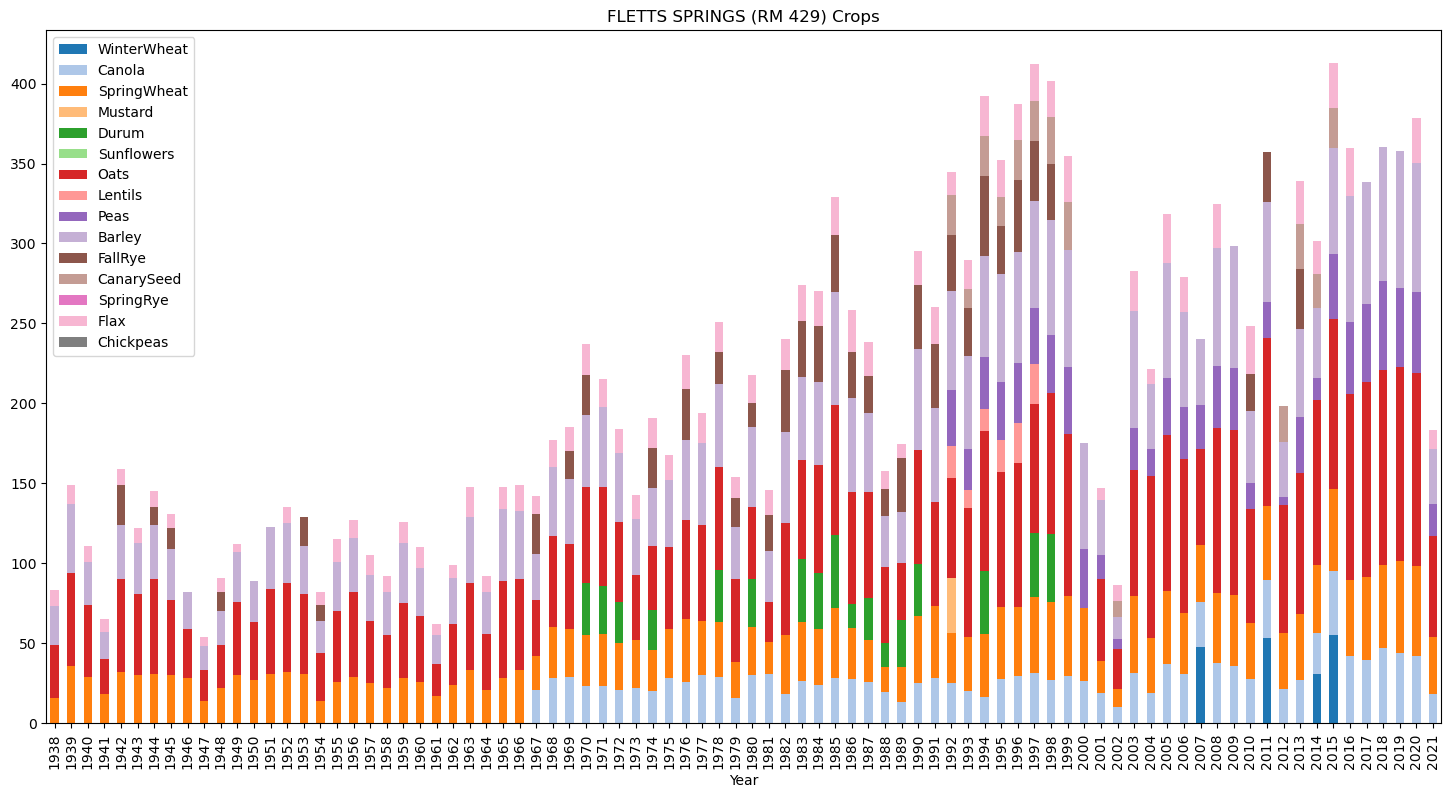

In [23]:
cmap = plt.cm.tab20
colors = cmap(np.arange(15) % cmap.N)

df_RM_429.plot(x='Year', kind='bar',figsize=(18,9), stacked=True,title='FLETT''S SPRINGS (RM 429) Crops',color=colors)
plt.savefig('RM429Crops.jpg',bbox_inches='tight')
plt.show()

In [24]:
df_RM_429 = df_csv.loc[df_csv['RM']==429][['Year','SpringWheat','Barley','Oats']]

In [25]:
df_RM_SpringWheat =df_csv.loc[df_csv['RM']==429][['Year', 'SpringWheat']]
df_RM_Barley =df_csv.loc[df_csv['RM']==429][['Year', 'Barley']]
df_RM_Oats =df_csv.loc[df_csv['RM']==429][['Year', 'Oats']]

In [26]:
df_RM_SpringWheat['Year'] = pd.to_datetime(df_RM_SpringWheat['Year'], format='%Y')
df_RM_SpringWheat = df_RM_SpringWheat.set_index('Year')

df_RM_Barley['Year'] = pd.to_datetime(df_RM_Barley['Year'], format='%Y')
df_RM_Barley = df_RM_Barley.set_index('Year')

df_RM_Oats['Year'] = pd.to_datetime(df_RM_Oats['Year'], format='%Y')
df_RM_Oats = df_RM_Oats.set_index('Year')

In [27]:
df_RM_429['Year'] = pd.to_datetime(df_RM_429['Year'], format='%Y')
df_RM_429 = df_RM_429.set_index('Year')
df_RM_429

,SpringWheat,Barley,Oats
Year,,,
1938-01-01,16.00,24.0,33.00
1939-01-01,36.00,43.0,58.00
1940-01-01,29.00,27.0,45.00
1941-01-01,18.00,17.0,22.00
1942-01-01,32.00,34.0,58.00
...,...,...,...
2017-01-01,51.96,76.6,121.99
2018-01-01,52.00,83.4,121.60
2019-01-01,57.50,85.7,121.50


## Forecast for RM429

<function matplotlib.pyplot.show(close=None, block=None)>

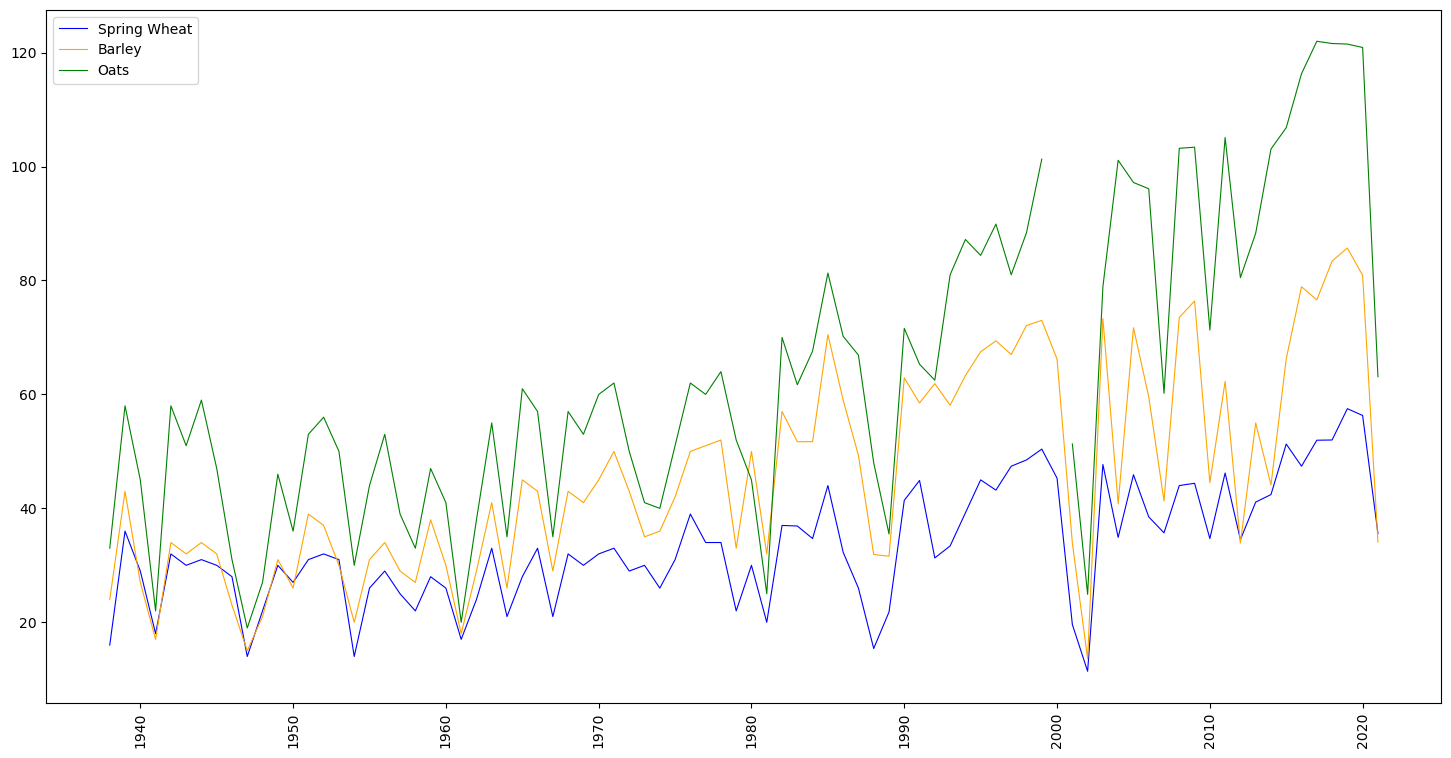

In [28]:
#fig, ax = plt.subplots(figsize=(6,6))

plt.plot(df_RM_429.index,df_RM_429['SpringWheat'], lw=0.8, color="blue", label="Spring Wheat")
plt.plot(df_RM_429.index,df_RM_429['Barley'], lw=0.8, color="orange", label="Barley")
plt.plot(df_RM_429.index,df_RM_429['Oats'], lw=0.8, color="green", label="Oats")
plt.xticks(rotation='vertical')
plt.legend()
plt.show

In [29]:
X = df_RM_429['SpringWheat']
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=27.523810, mean2=39.075476
variance1=35.279907, variance2=115.551045


# Time Forecasting Model

#### Mean Absolute Percentage Error

In [30]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)
df_MAPE = pd.DataFrame(columns=('Model', 'MAPE'))
df_MAPE

,Model,MAPE


#### Ad Fuller Test

In [31]:
# Import adfuller
from statsmodels.tsa.stattools import adfuller

def adf_test(df_test):
    result = adfuller(df_RM_429['SpringWheat'])
    print('ADF Test Statistic: %.2f' % result[0])
    print('#Lags Used: '+str(result[2]))
    print('5%% Critical Value: %.2f' % result[4]['5%'])
    print('p-value: %.2f' % result[1])


In [32]:
adf_test(df_RM_429['SpringWheat'])

ADF Test Statistic: -4.92
#Lags Used: 0
5% Critical Value: -2.90
p-value: 0.00


#### Seasonal Decompose

<Figure size 1800x900 with 0 Axes>

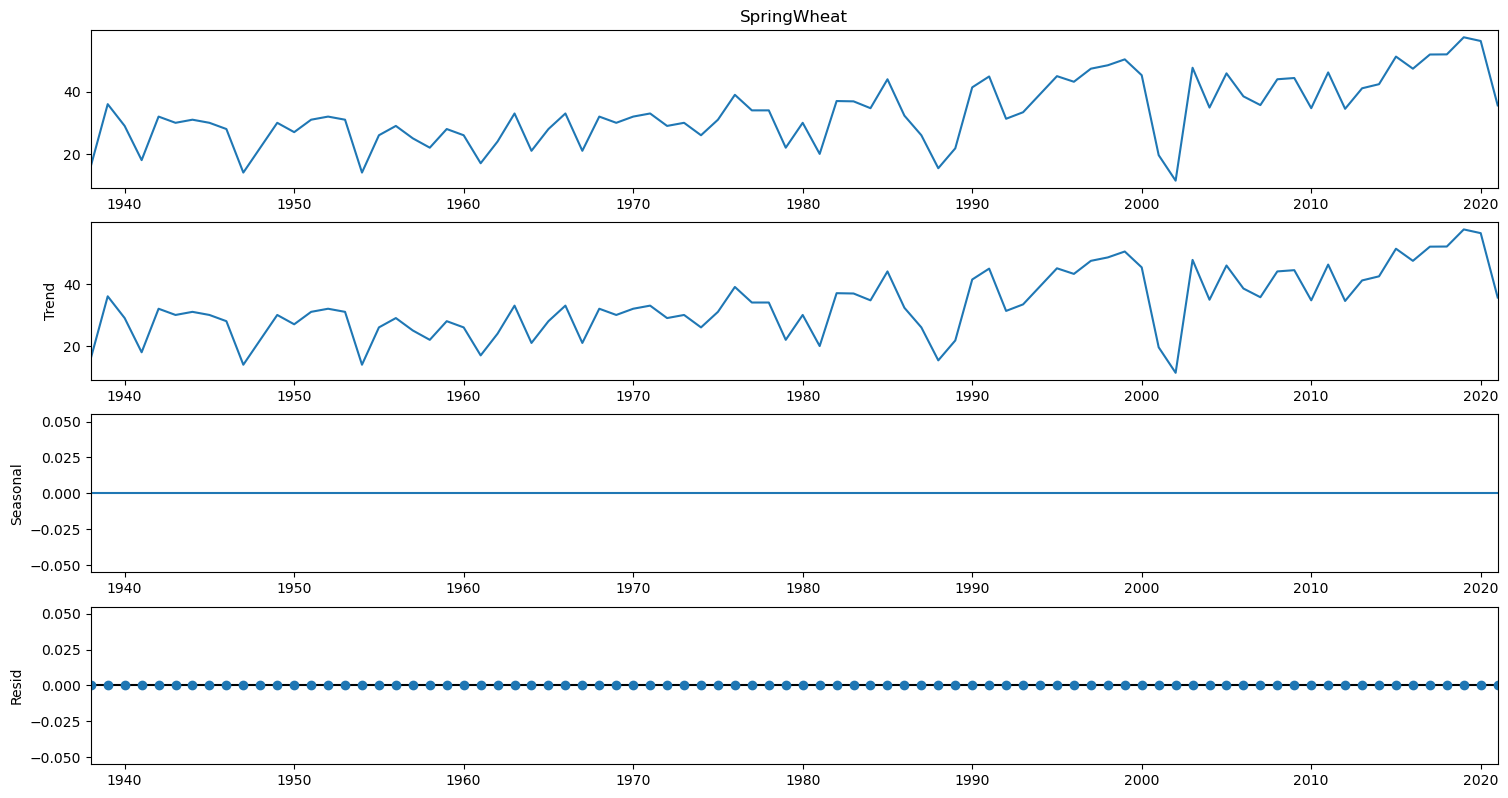

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_RM_429['SpringWheat'])  
figure = plt.figure()  
figure = decomposition.plot()  
figure.set_size_inches(15, 8)

In [34]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=2).mean()
    rolstd = timeseries.rolling(window=2).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
# test_stationarity(df_RM_429['SpringWheat'])

#### Train and Test data split at 2011

In [35]:
train = df_RM_429[:'2010-01-01']['SpringWheat']    # until 2010
len(train)

test = df_RM_429['2011-01-01':]['SpringWheat']     # from 2011
len(test) 

11

## Autoregression

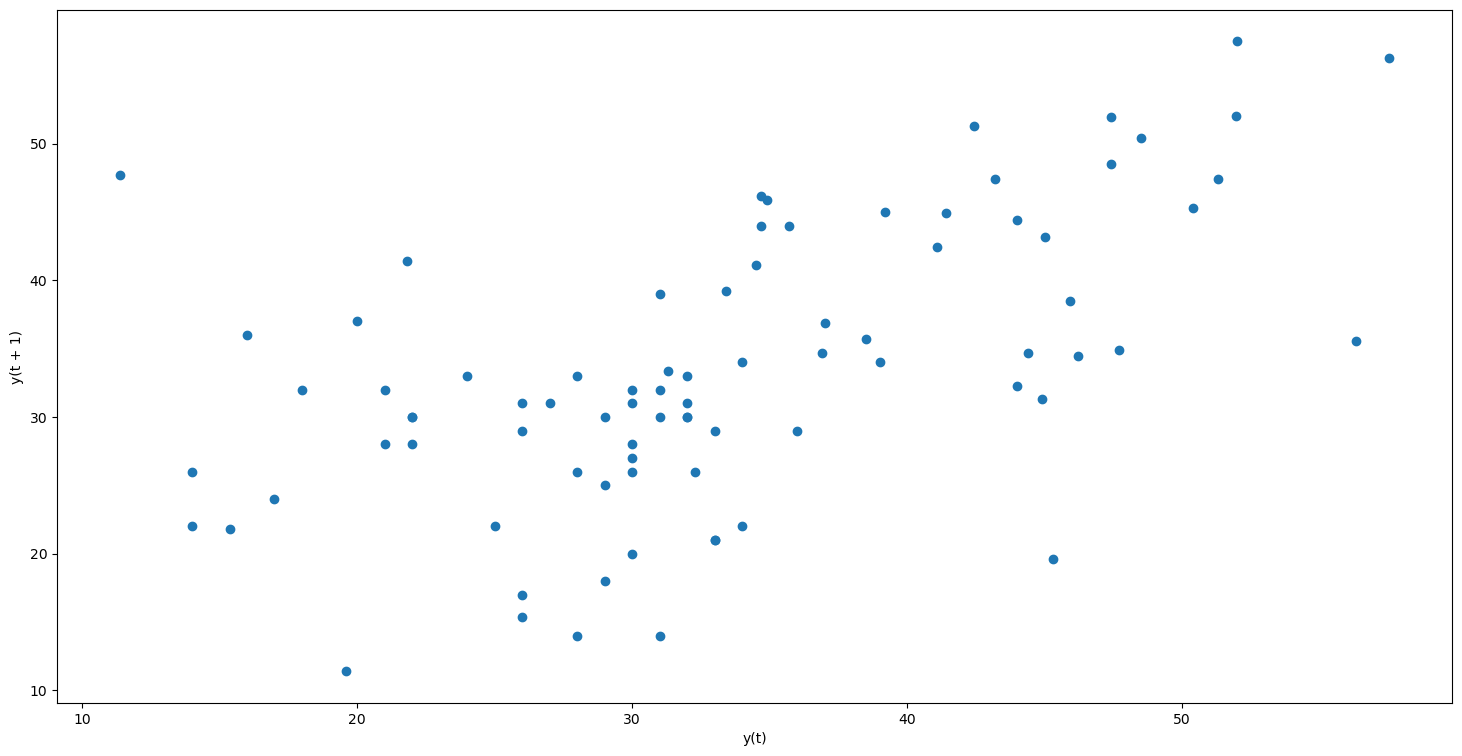

In [36]:
from pandas.plotting import lag_plot
lag_plot(df_RM_429['SpringWheat'])
plt.show()

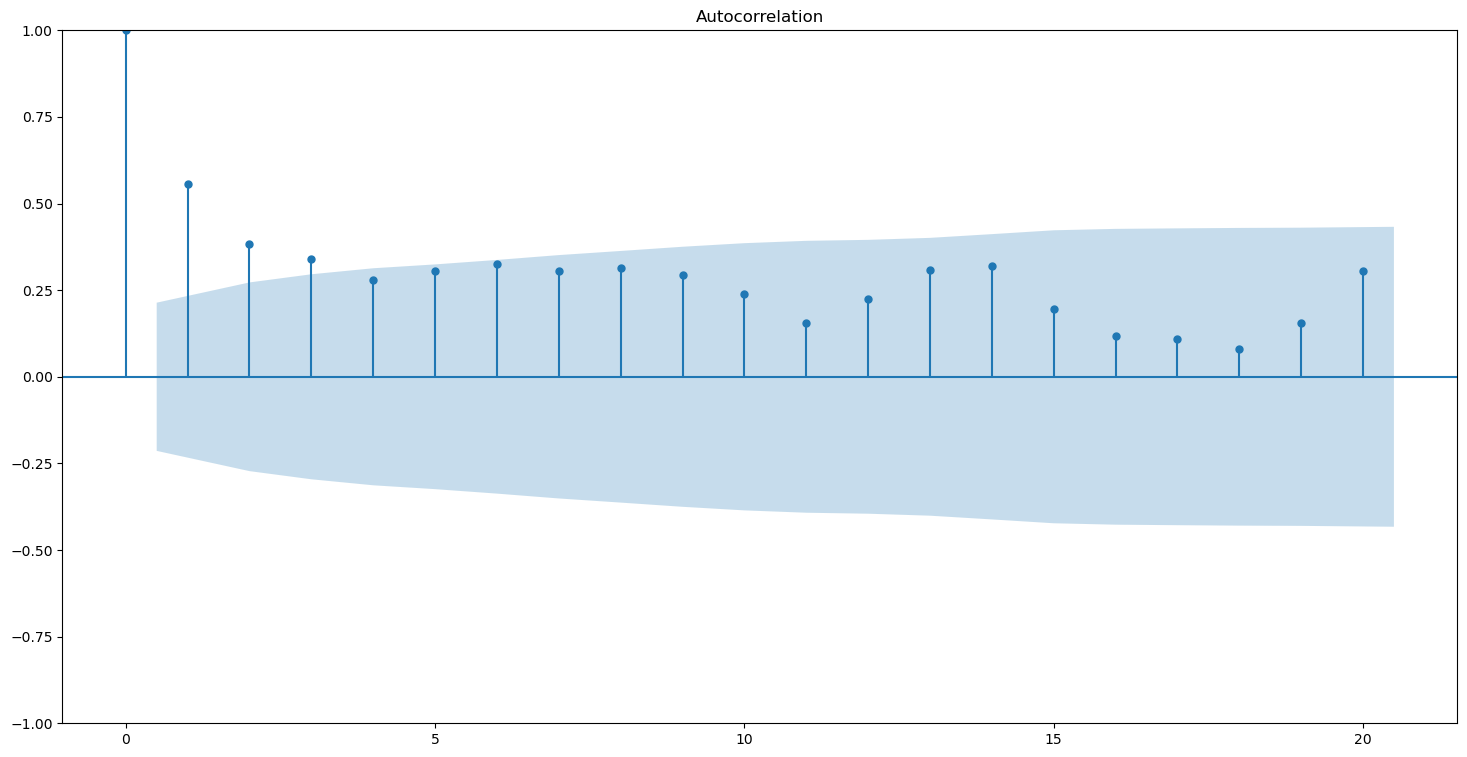

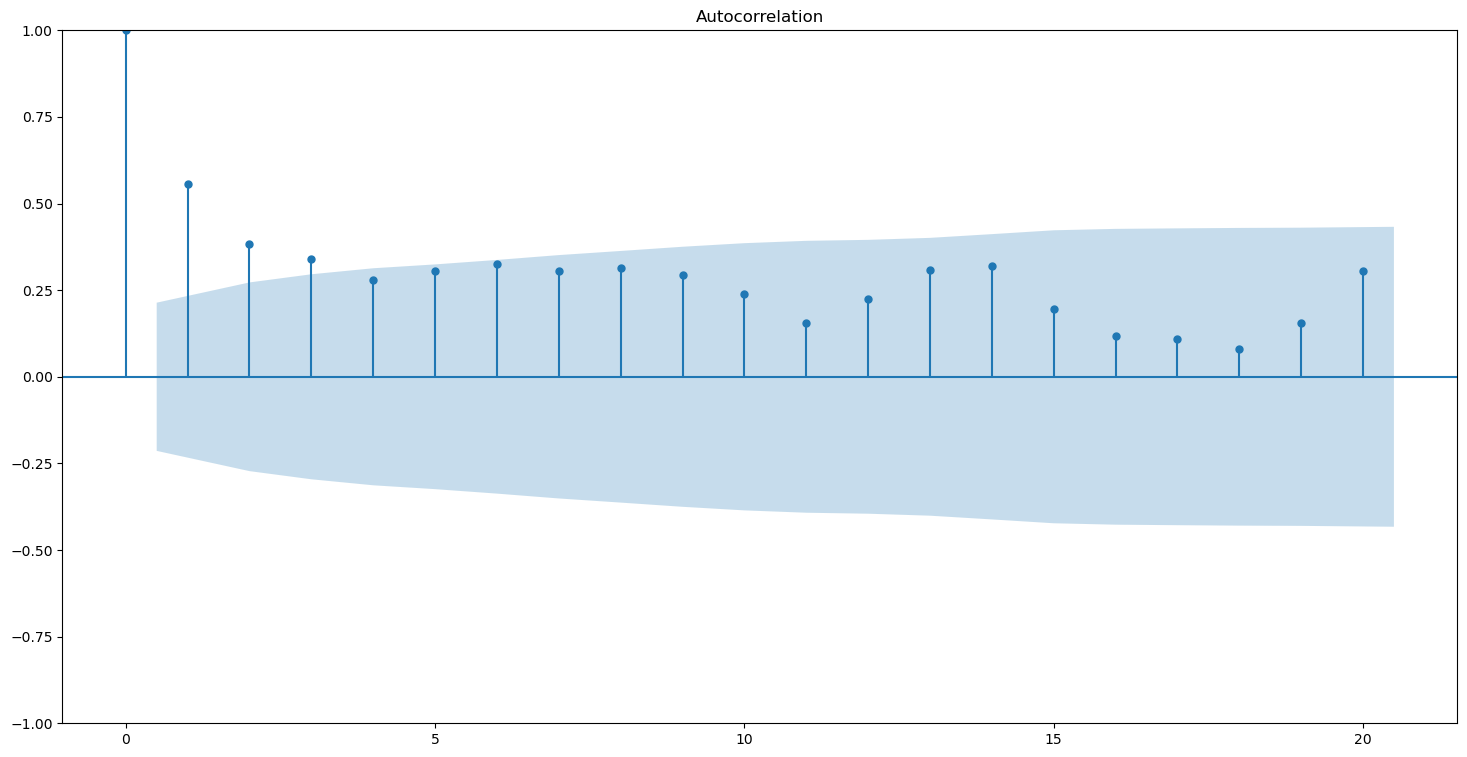

In [37]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_RM_429['SpringWheat'])

In [38]:
from statsmodels.tsa.ar_model import AutoReg

# train autoregression
ar_model = AutoReg(train.dropna(),lags=1).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:            SpringWheat   No. Observations:                   73
Model:                     AutoReg(1)   Log Likelihood                -252.838
Method:               Conditional MLE   S.D. of innovations              8.107
Date:                Mon, 13 Mar 2023   AIC                            511.676
Time:                        23:32:49   BIC                            518.506
Sample:                    01-01-1939   HQIC                           514.395
                         - 01-01-2010                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             18.3686      3.398      5.405      0.000      11.708      25.029
SpringWheat.L1     0.4195      0.105      4.013      0.000       0.215       0.624
                                    

/Users/sbitara/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/sbitara/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:1064: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(lag_repr) ** -1


/Users/sbitara/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


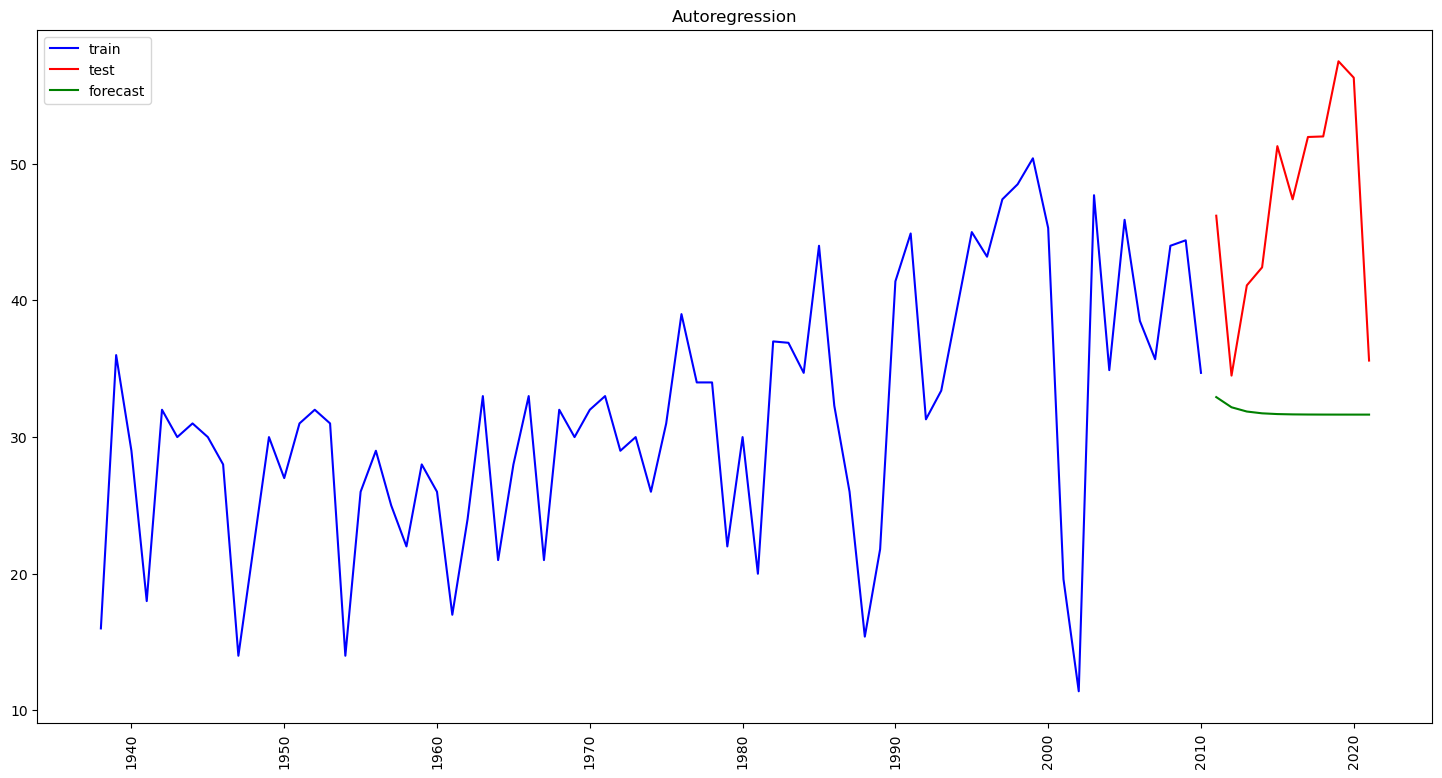

In [39]:
#
# Make the predictions
#
y_pred = ar_model.predict(start=len(train), end=(len(df_RM_429)-1), dynamic=False)
#
# Plot the prediction vs test data
#
from matplotlib import pyplot
plt.title('Autoregression')
plt.plot(train,color='blue',label='train' )
plt.plot(test, color='red',label='test')
plt.plot(y_pred,color='green',label='forecast')
plt.xticks(rotation='vertical')
plt.legend()
plt.savefig('Autoregression.jpg',bbox_inches='tight')
plt.show()

In [40]:
ar_mape = mape(test, y_pred)
df_MAPE.loc[len(df_MAPE.index)] =['Autoregression',ar_mape]
print(f'Autregression: {ar_mape}%')


Autregression: 30.24%


## Moving Average

In [41]:
y_pred = df_RM_429['SpringWheat'].copy()
ma_window = 2
y_pred = df_RM_429['SpringWheat'].rolling(ma_window).mean()
y_pred[len(train):] = y_pred[len(train)-1]
y_pred

Year
1938-01-01      NaN
1939-01-01    26.00
1940-01-01    32.50
1941-01-01    23.50
1942-01-01    25.00
              ...  
2017-01-01    39.55
2018-01-01    39.55
2019-01-01    39.55
2020-01-01    39.55
2021-01-01    39.55
Name: SpringWheat, Length: 84, dtype: float64

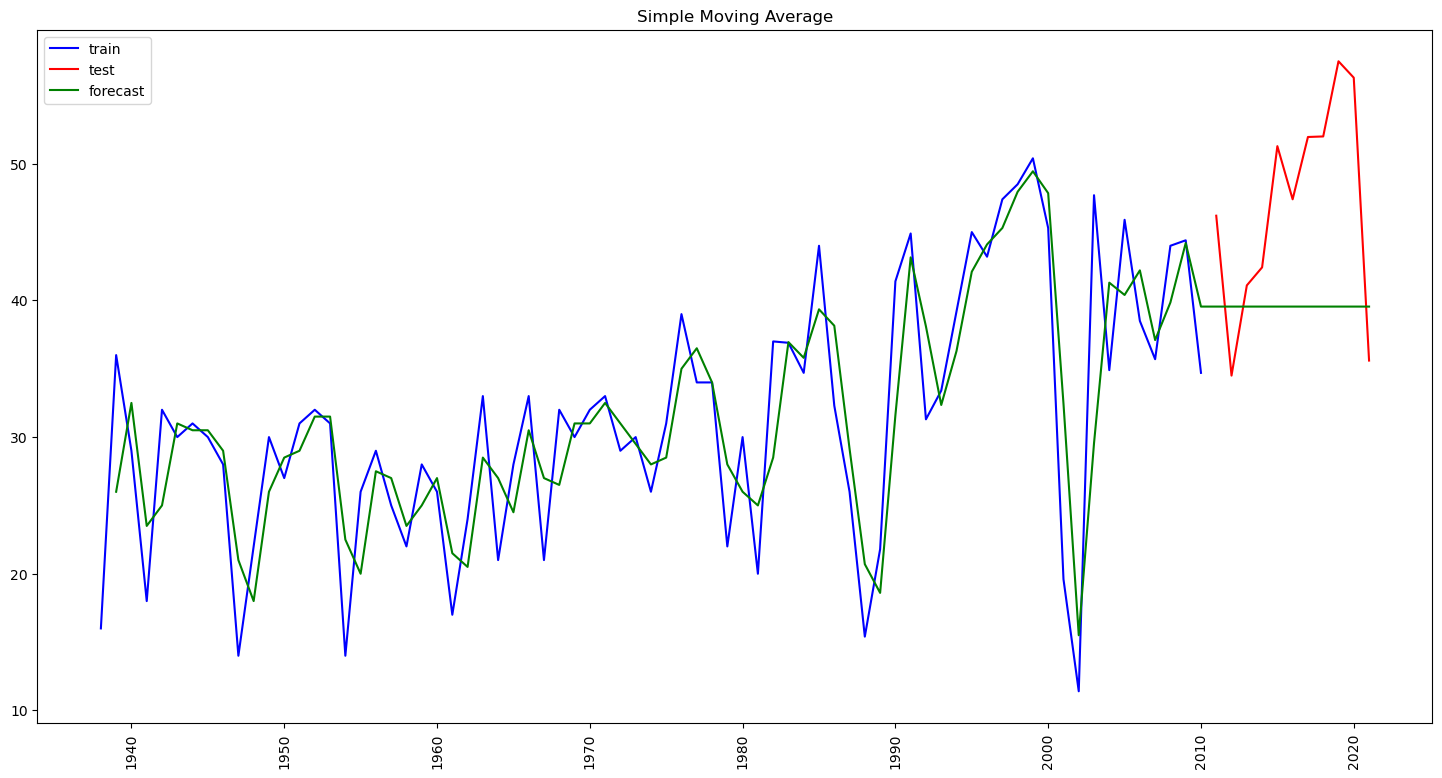

In [42]:
#plt.figure(figsize=(8,8))
#plt.grid()
plt.plot(train, label='train',color='blue')
plt.plot(test, label='test',color='red')
plt.plot(y_pred, label='forecast',color='green')
plt.xticks(rotation='vertical')
plt.legend(loc='best')
plt.title('Simple Moving Average')
plt.savefig('Simple Moving Average.jpg',bbox_inches='tight')
plt.show()

In [43]:
ma_mape = mape(test, y_pred)
df_MAPE.loc[len(df_MAPE.index)] =['Simple Moving Average Method',ma_mape]
print(f'Moving Average: {ma_mape}%')

Moving Average: 18.08%


## Simple Exponential Smoothing

In [44]:
from statsmodels.tsa.api import SimpleExpSmoothing
#import plotly.express as px

alpha = 0.8
ses = SimpleExpSmoothing(df_RM_429['SpringWheat'])
model = ses.fit(smoothing_level = alpha, optimized = False)

forecast = model.forecast(5)

forecast

/Users/sbitara/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


2022-01-01    39.742606
2023-01-01    39.742606
2024-01-01    39.742606
2025-01-01    39.742606
2026-01-01    39.742606
Freq: AS-JAN, dtype: float64

/Users/sbitara/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/sbitara/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/sbitara/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


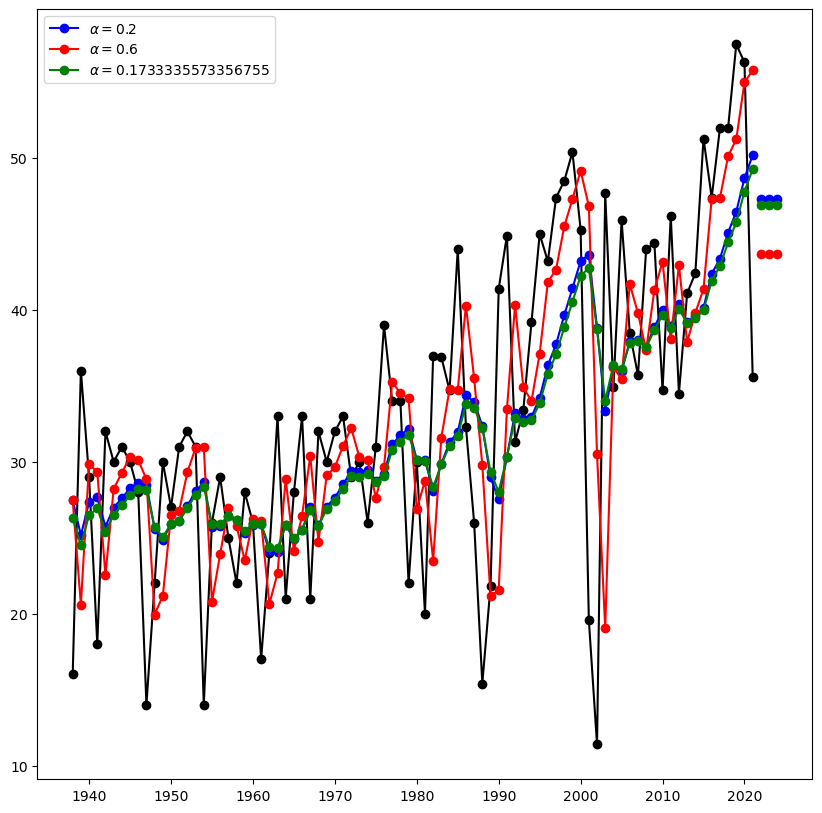

In [45]:
fit1 = SimpleExpSmoothing(df_RM_429['SpringWheat'], initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False
)
fcast1 = fit1.forecast(3).rename(r"$\alpha=0.2$")
fit2 = SimpleExpSmoothing(df_RM_429['SpringWheat'], initialization_method="heuristic").fit(
    smoothing_level=0.6, optimized=False
)
fcast2 = fit2.forecast(3).rename(r"$\alpha=0.6$")
fit3 = SimpleExpSmoothing(df_RM_429['SpringWheat'], initialization_method="estimated").fit()
fcast3 = fit3.forecast(3).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

plt.figure(figsize=(10, 10))
plt.plot(df_RM_429['SpringWheat'], marker="o", color="black")
plt.plot(fit1.fittedvalues, marker="o", color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, marker="o", color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(fit3.fittedvalues, marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])


In [46]:
from sklearn.metrics import mean_absolute_error

ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.2)

y_pred = ses_model.forecast(len(test))

ses_mape = mape(test, y_pred)

df_MAPE.loc[len(df_MAPE.index)] = ['Simple Exponential Smoothing',ses_mape]
print(f'Simple Exponential Smoothing: {ses_mape}%')


Simple Exponential Smoothing: 18.81%


/Users/sbitara/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


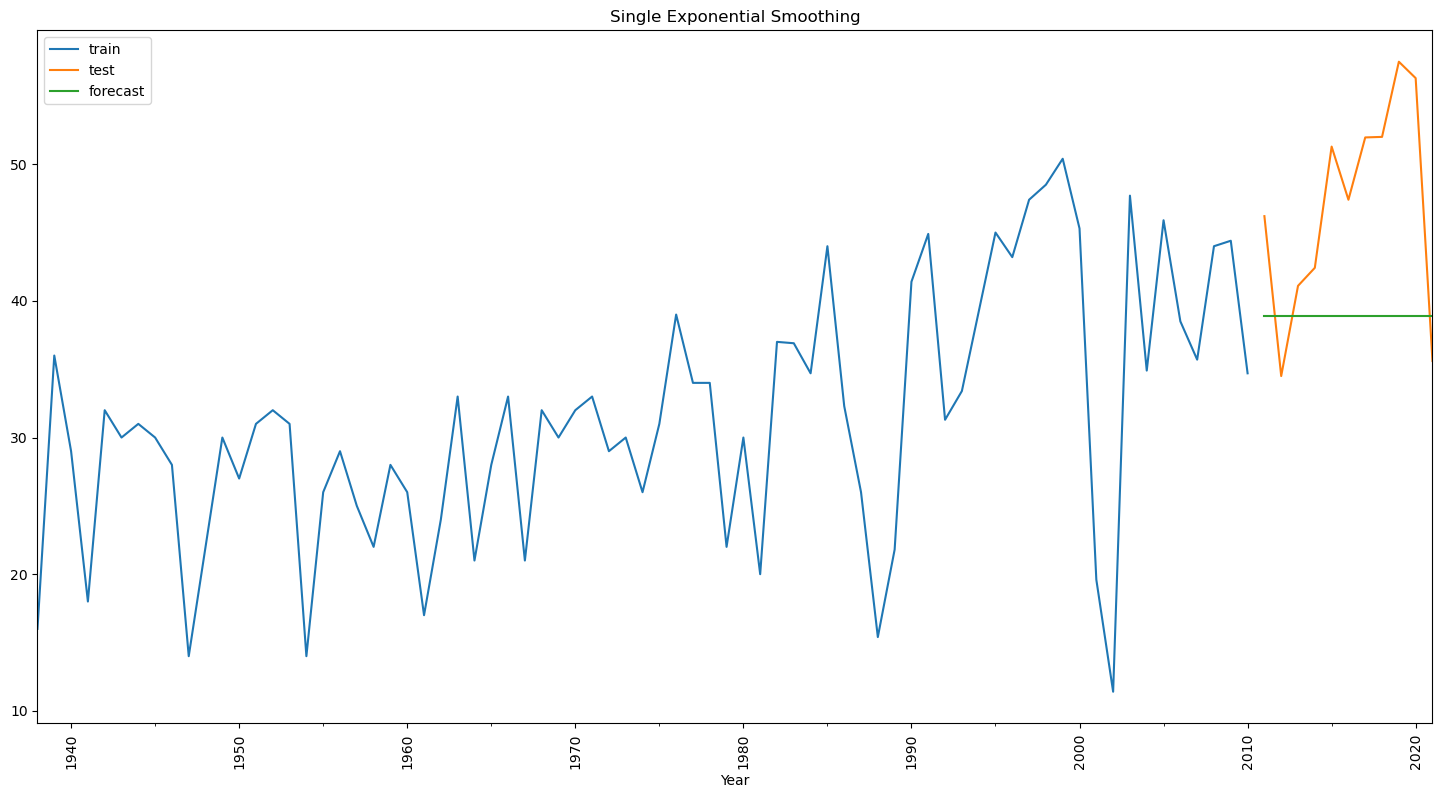

In [47]:
train.plot(title="Single Exponential Smoothing",label='train')
test.plot(label='test')
y_pred.plot(label='forecast')
plt.xticks(rotation='vertical')
plt.legend()
plt.savefig('Spring Wheat SES.jpg',bbox_inches='tight')
plt.show()

## Double Exponential Smoothing

In [48]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
double_model = ExponentialSmoothing(train,trend='add').fit()
y_pred = double_model.forecast(11).rename('DES Forecast')

/Users/sbitara/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


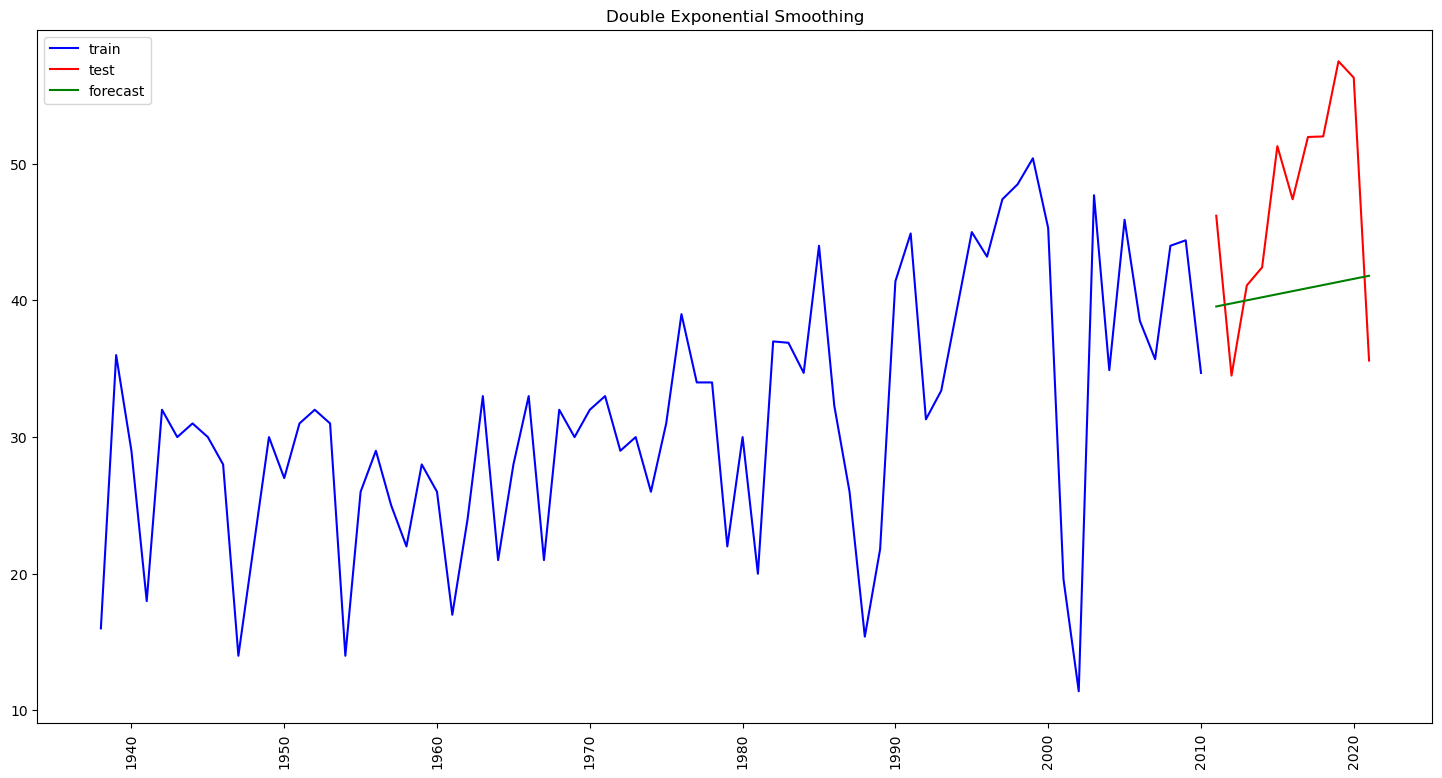

In [49]:
plt.title('Double Exponential Smoothing')
plt.plot(train,color='blue',label='train')
plt.plot(test, color='red',label='test')
plt.plot(y_pred,color='green',label='forecast')
plt.xticks(rotation='vertical')
plt.legend()
plt.savefig('Double Exponential Smoothing.jpg',bbox_inches='tight')
plt.show()

In [50]:
des_mape = mape(test, y_pred)
df_MAPE.loc[len(df_MAPE.index)] =['Double Exponential Smoothing',des_mape]
print(f'Double Exponential Smoothing: {des_mape}%')


Double Exponential Smoothing: 16.97%


## Triple Exponential Smoothing

In [51]:
triple_model = ExponentialSmoothing(train,trend='add',seasonal='add',seasonal_periods=12).fit()
y_pred = triple_model.forecast(11).rename('TES Forecast')

/Users/sbitara/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


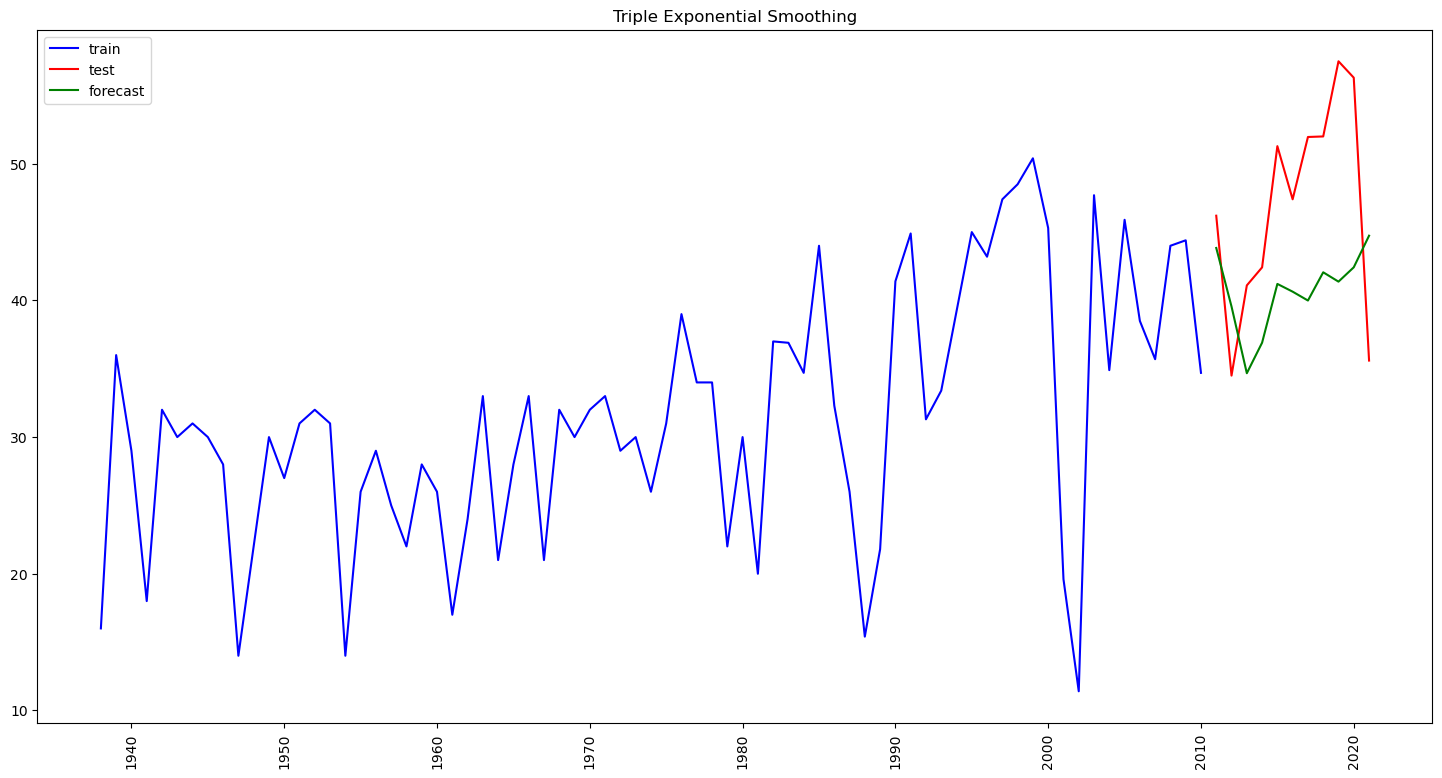

In [52]:

plt.xticks(rotation='vertical')
plt.plot(train,color='blue',label='train')
plt.plot(test, color='red',label='test')
plt.plot(y_pred,color='green',label='forecast')
plt.title('Triple Exponential Smoothing')
plt.legend()
plt.savefig('Triple Exponential Smoothing.jpg',bbox_inches='tight')
plt.show()

In [53]:
tes_mape = mape(test, y_pred)
df_MAPE.loc[len(df_MAPE.index)] =['Triple Exponential Smoothing',tes_mape]
print(f'Triple Exponential Smoothing: {tes_mape}%')


Triple Exponential Smoothing: 18.44%


## Mean Absolute Percentage Error

In [54]:
df_MAPE

,Model,MAPE
0,Autoregression,30.24
1,Simple Moving Average Method,18.08
2,Simple Exponential Smoothing,18.81
3,Double Exponential Smoothing,16.97
4,Triple Exponential Smoothing,18.44


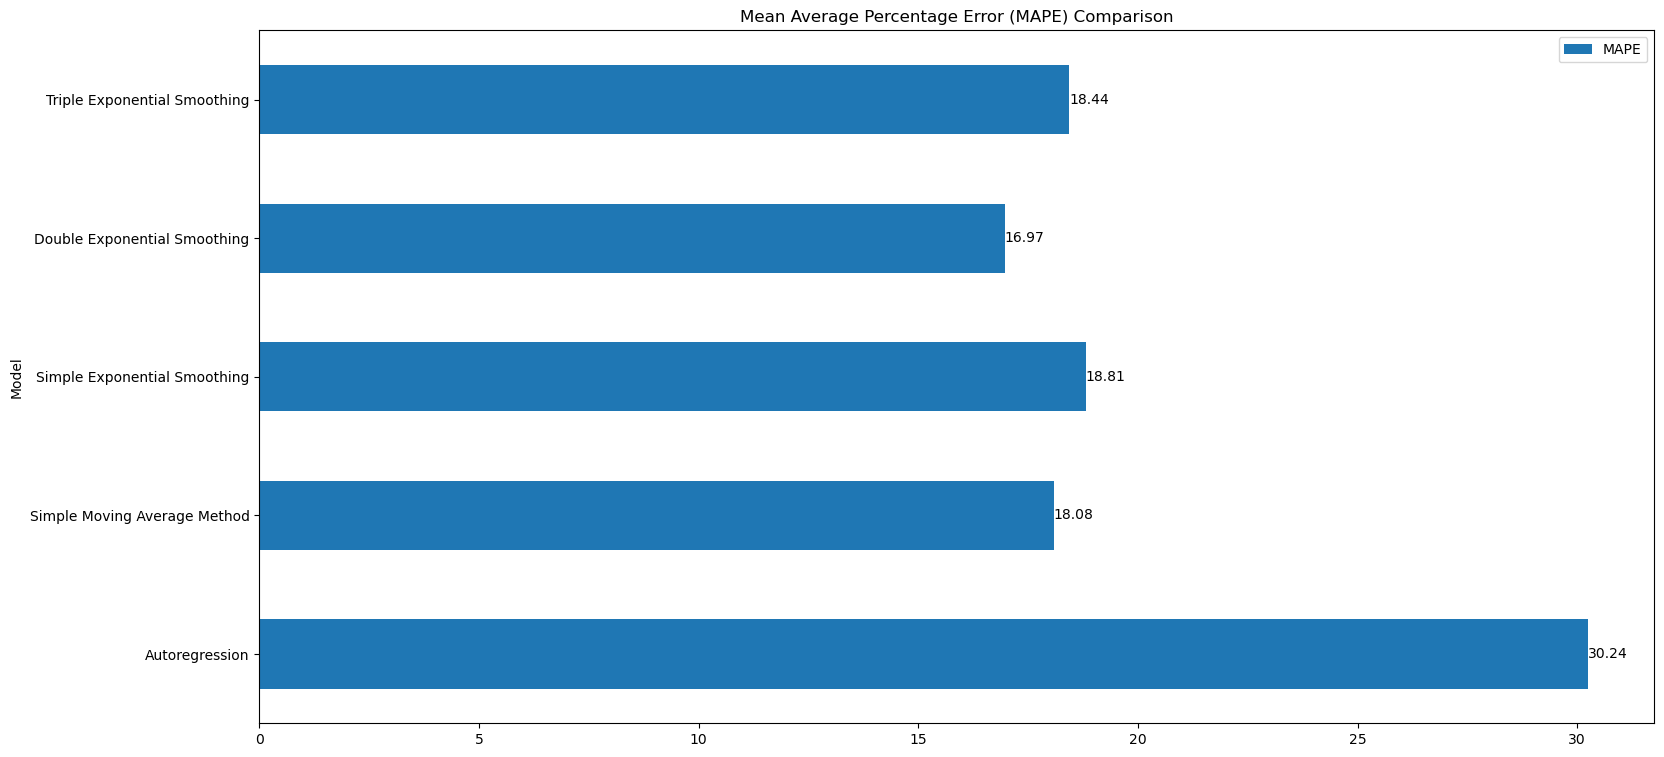

In [55]:
plt.rcParams['figure.figsize'] = (18, 9)
ax=df_MAPE.plot(kind='barh', x='Model',y='MAPE',figsize=(18,9),title='Mean Average Percentage Error (MAPE) Comparison')
ax.bar_label(ax.containers[0], label_type='edge')

plt.savefig('MAPE.jpg',bbox_inches='tight')